In [2]:
# things for colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/LCP-modB/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/LCP-modB


In [3]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LCP mod. B – Exercise n. 1: Gradient Descent & DNNs

### List of students

```
Davide Bacilieri 2089214
Lorenzo Barbiero 2082142
Guglielmo Bordin 2088622
Alessio Pitteri  2090594
```

## Step 0. Importing Stuff

In [4]:
import numpy as np

import keras as kr
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.optimizers as opt

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='copper')
plt.rcParams['font.size'] = 15

import seaborn as sns

%run nonlinear_function.py

# set tensorflow seed for reproducibility
np.random.seed(12345)
import tensorflow.random as tfr
tfr.set_seed(12345)

## Step 1. Loading and Processing the Data
We’ll be doing cross validation later, so we’re not splitting the dataset in training and test sets until after we’ve chosen the best hyperparameters.

In [5]:
TYPE = 1
x = np.loadtxt(filename('data', TYPE), delimiter=' ')
y = np.loadtxt(filename('labels', TYPE), delimiter=' ')
N = len(x)     # number of samples
L = len(x[0])  # dimension of each sample

# rescaling of the data (as done in class)
x /= 50

print(f'Number of samples: {N}')

Number of samples: 4000


## Step 2. Definition of the Model
Here we build the architecture: we’ve chosen to build a network with four hidden 20-neuron layers followed by a single dropout layer. The output layer is a single neuron with sigmoid activation, to map the output to the range $(0, 1)$.

The module construction function requires three inputs: the dropout percentage for the second-to-last layer, the optimizer name, and the learning rate value. We’ll optimize all of these parameters through a grid search later on.

In [6]:
# for some reason, GridSearchCV needs a default optimizer value here
def compile_model(dropout_rate, learning_rate, optimizer=opt.Adam):
    # build DNN layer by layer
    model = Sequential()
    # input layer
    model.add(Dense(L, input_shape=(L, ), activation='relu'))
    # 4 hidden layers
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    # dropout layer
    model.add(Dropout(dropout_rate))
    # last single-neuron layer
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(loss=kr.losses.binary_crossentropy,
                  optimizer=optimizer(learning_rate=learning_rate),
                  metrics=['accuracy'])

    return model

## Step 3. Grid Search Optimization
Here we’ll perform a grid search optimization with cross-validation, thanks to the function `GridSearchCV` from `scikit-learn`. As anticipated, we’ll search for the best combination of the optimization algorithm, its learning rate and the dropout rate for the second-to-last layer.

In [7]:
optalg_list = [opt.Adam, opt.RMSprop, opt.Nadam, opt.Adamax]
lrate_list = [10**i for i in range(-2, -5, -1)]
dout_list = [10**i for i in range(-1, -5, -1)]

# define parameter dictionary
param_grid = dict(optimizer=optalg_list,
                  learning_rate=lrate_list,
                  dropout_rate=dout_list)

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(model=compile_model,
                                   optimizer=opt.Adam,
                                   dropout_rate=0.01,
                                   learning_rate=0.01,
                                   epochs=400,
                                   batch_size=50,
                                   verbose=0)
# call scikit grid search module
# adjust n_jobs to number of cores on your machine
grid = GridSearchCV(estimator=model_gridsearch,
                    param_grid=param_grid,
                    n_jobs=2, # 2 for colab
                    cv=4)

In [ ]:
grid_result = grid.fit(x, y)

# summarize results
print(f'Best:\n {grid_result.best_score_}')
print(f'using:\n {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, par in zip(means, stds, params):
    print(f'Score {mean} ± {stdev} with: {par}')

## Step 4. Visualization of the Grid Search Results
Here we’ll plot the mean cross-validation score of the various combination of parameters analysed in the grid search.

[(0.95525, {'dropout_rate': 0.1, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.93, {'dropout_rate': 0.1, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.8594999999999999, {'dropout_rate': 0.1, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.9239999999999999, {'dropout_rate': 0.01, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.95525, {'dropout_rate': 0.01, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.8775000000000001, {'dropout_rate': 0.01, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.9007499999999999, {'dropout_rate': 0.001, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}), (0.9329999999999999, {'dropout_rate': 0.001, 'learning_rate': 0.001, 'optimizer': <class 'keras.opti

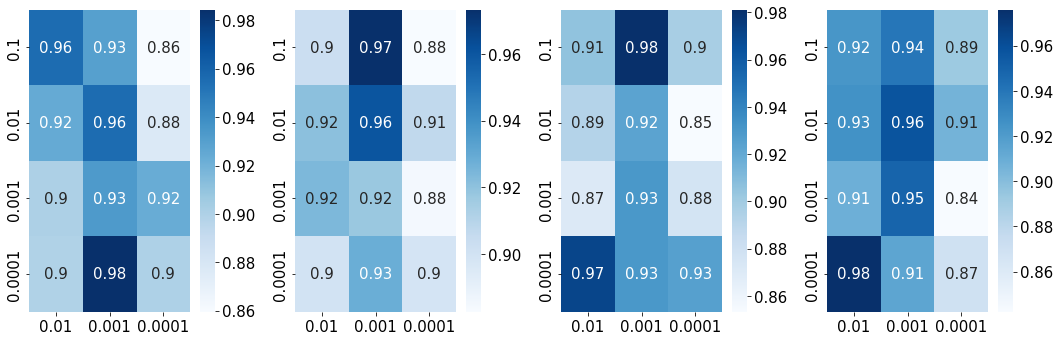

In [ ]:
glob = [(m, p) for m, p in zip(means, params)]
# sort by optimizer name, alphabetically
glob = sorted(glob, key=lambda i: str(i[1]['optimizer']))

n_lrate = len(lrate_list)
n_dout = len(dout_list)
opt_chunk = n_lrate * n_dout

# human readable names for the algorithms
opt_names = ['Adam', 'Adamax', 'Nadam', 'RMSprop']

fig, ax = plt.subplots(ncols=len(optalg_list), nrows=1, figsize=(16, 7))
for i_op in range(len(optalg_list)):
    # all data from the i_op-th optimizer
    op = glob[i_op * opt_chunk:(i_op + 1) * opt_chunk]
    # dataframe with different learning rates in the columns
    # and different dropouts in the rows
    d = [[op[i + n_lrate * j][0]
          for i in range(len(lrate_list))]
         for j in range(len(dout_list))]
    df = pd.DataFrame(d, index=dout_list, columns=lrate_list)
    sn.heatmap(df, annot=True, cmap='Blues',
               # common colorbar displayed in the last plot
               ax=ax[i_op], vmin=0.8, vmax=1, cbar=o==3)
    # set optimizer name as title
    ax[i_op].set_title(opt_names[i_op])

# common labels
fig.supxlabel('Learning rate')
fig.supylabel('Dropout value')
fig.tight_layout()
#0.98125 ± 0.00432290411644765  for Nadam
#0.9844999999999999 ± 0.0038405728739343073 for Adam